# **Install Required Libraries**

In [ ]:
!pip install netCDF4 wget keras-tcn

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 26.2 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=74f0715bb4fc309e3d0bfa12f3b8ae42b69a7be28fd2299d9ec6f7c032d7e3b4
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


# **import the required libraries**

In [ ]:
from google.colab import drive
import wget
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

# **Mounts the user's Google Drive to access and store files**

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
save_folder = '/content/drive/My Drive/Climate_Data/'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# **Download Data File**

In [ ]:
import wget
import sys
def bar_progress(current, total, width=80):
  progress_message = "Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total)
  sys.stdout.write("\r" + progress_message)
  sys.stdout.flush()

year = 2010   # put here any year you need
wget.download(f"https://data.giss.nasa.gov/impacts/agmipcf/agcfsr/AgCFSR_{year}_tmax.nc4", bar=bar_progress)

Downloading: 100% [106364510 / 106364510] bytes

'AgCFSR_2010_tmax.nc4'

# **Load NetCDF Data**

In [ ]:
file_path = 'AgCFSR_2010_tmax.nc4'
nc_data = Dataset(file_path, mode='r')

print(nc_data)
print(nc_data.variables.keys())

<class 'netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    history: Wed Jul 10 23:58:13 EDT 2013
    source: AgMIP / Alex Ruane
    title: AgCFSR Maximum Temperature
    center: NASA GISS
    dimensions(sizes): time(365), latitude(720), longitude(1440)
    variables(dimensions): int16 tmax(time, latitude, longitude), float32 time(time), float32 latitude(latitude), float32 longitude(longitude)
    groups: 
dict_keys(['tmax', 'time', 'latitude', 'longitude'])


In [ ]:
print(nc_data.variables['tmax'])  # Maximum Temperature

<class 'netCDF4.Variable'>
int16 tmax(time, latitude, longitude)
    _FillValue: 32767
    description: Maximum Temperature
    units: Degrees Celsius
    add_offset: 0.0
    scale_factor: 0.01
    vMin_original_data: -59.1
    vMax_original_data: 54.8
    vRange: 113.899994
unlimited dimensions: time
current shape = (365, 720, 1440)
filling on


In [ ]:
nc_data.variables['tmax'].shape

(365, 720, 1440)

# **Visualizes the maximum temperature (`tmax`) for day 1 in 2010**

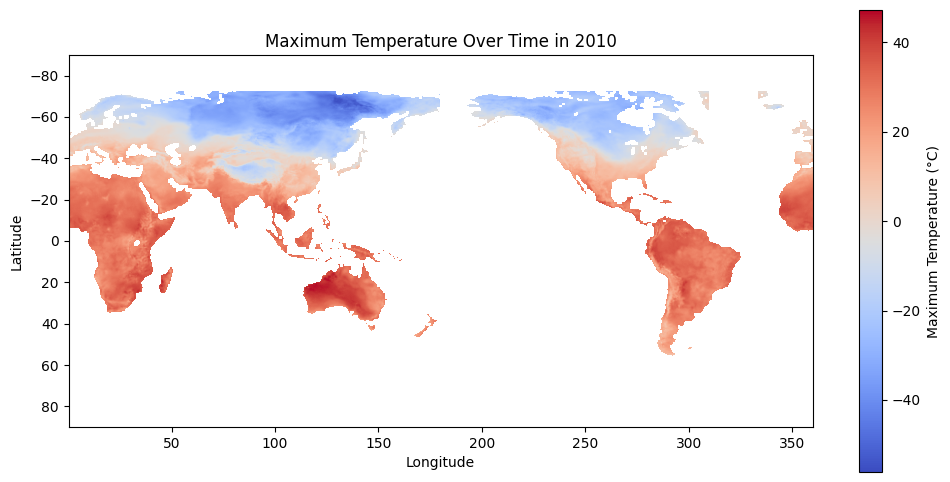

In [ ]:
tmax = nc_data.variables["tmax"][:]  # Maximum Temperature
latitude = nc_data.variables["latitude"][:]
longitude = nc_data.variables["longitude"][:]

fig, ax = plt.subplots(figsize=(12, 6))

im = ax.imshow(
    tmax[0, :, :],
    origin="lower",
    cmap="coolwarm",
    extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()],
)
ax.invert_yaxis()
plt.colorbar(im, label="Maximum Temperature (°C)", ax=ax)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Maximum Temperature Over Time in 2010")
plt.show()

# **Animate Temperature Over Time**

In [ ]:
tmax = nc_data.variables["tmax"][:]
latitude = nc_data.variables["latitude"][:]
longitude = nc_data.variables["longitude"][:]

fig, ax = plt.subplots(figsize=(12, 6))

im = ax.imshow(
    tmax[0, :, :],
    origin="lower",
    cmap="coolwarm",
    extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()],
)
ax.invert_yaxis()
plt.colorbar(im, label="Maximum Temperature (°C)", ax=ax)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Maximum Temperature Over Time")

def update(frame):
    im.set_data(tmax[frame, :, :])
    ax.set_title(f"Maximum Temperature at Day {frame}")
    return im,

anim = FuncAnimation(fig, update, frames=tmax.shape[0], interval=200, blit=False)

anim.save("temperature_animation.gif", writer="pillow")
print("Animation saved as 'temperature_animation.gif'")

# **Data Preprocessing**

In [ ]:
raw_tmax = nc_data.variables['tmax'][:]
tmax_original = raw_tmax * 0.01        # darabtha 3alshan fel description of the tmax he scaled them by dividing with 0.01 3lshan el storage
tmax_original = np.ma.masked_where(raw_tmax == 32767, tmax_original)   #fel description 7atet el null values b 32767 f ana bshelhom to get the original data

In [ ]:
time = nc_data.variables['time'][:]               # bageeb kol el time and so on for other variables
latitude = nc_data.variables['latitude'][:]
longitude = nc_data.variables['longitude'][:]
temperature = nc_data.variables['tmax'][:]

time_flat = np.repeat(time, len(latitude) * len(longitude))         #flatten the data
lat_flat = np.tile(np.repeat(latitude, len(longitude)), len(time))
lon_flat = np.tile(longitude, len(time) * len(latitude))
temp_flat = tmax_original.flatten()

valid_indices = ~np.ma.getmask(temp_flat)       # basheel el masked values(like nulls i think)
time_valid = time_flat[valid_indices]
lat_valid = lat_flat[valid_indices]
lon_valid = lon_flat[valid_indices]
temp_valid = temp_flat[valid_indices]

# Create DataFrame
df = pd.DataFrame({
    'Time': time_valid,
    'Latitude': lat_valid,
    'Longitude': lon_valid,
    'Temperature': temp_valid
})

# Display the first few rows
print(df.head())
print(df)

In [ ]:
print(df.isnull().sum())

Time           0
Latitude       0
Longitude      0
Temperature    0
dtype: int64


## **Normalize Data**

In [ ]:
temperature = df['Temperature']
#Data Normalization
temperature_normalized = (temperature - temperature.min()) / (temperature.max() - temperature.min())
df['Temperature_Normalized'] = temperature_normalized

In [ ]:
normalized_temp = df['Temperature_Normalized']

# **Preparing Data for Time Series Modeling**


In [ ]:
# b3mel el X patterns to train on it w el Y b3d akher 7aga fel window
def pattern_function(normalized_temp, window_size):
    pattern = []
    targets = []
    if len(normalized_temp) <= window_size:
        raise ValueError("input is less than one window:(")

    for i in range(len(normalized_temp) - window_size):
        patt = normalized_temp[i:i + window_size]
        target = normalized_temp[i + window_size]
        pattern.append(patt)
        targets.append(target)
    return np.array(pattern), np.array(targets)

In [ ]:
window_size = 10
sample = normalized_temp[:100000]
X, y = pattern_function(sample, window_size)

In [ ]:
sample_two =

In [ ]:
X = X.reshape(X.shape[0], X.shape[1], 1)   #3alashan el LSTM bya5od el input 3d (len(x)3adad el samples, window_size, num_features)

In [ ]:
X.shape

(99990, 10, 1)

# **Split Data for Training and Testing**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (79992, 10, 1)
X_test shape: (19998, 10, 1)
y_train shape: (79992,)
y_test shape: (19998,)


In [ ]:
print(np.isnan(X_train).any(), np.isnan(y_train).any())  # Check for NaN
print(np.isinf(X_train).any(), np.isinf(y_train).any())  # Check for Inf

False False
False False


 # **Building Time series Models for Comparison**

We will compare time series models like LSTM, TCN and GRU

## **Building LSTM**

In [ ]:
model_LSTM = Sequential([
    LSTM(50, activation='tanh', return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(50, activation='tanh'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

model_LSTM.summary()
model_LSTM.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 50)            10400     
                                                                 
 dropout_6 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# adding early stop to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history_lstm = model_LSTM.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,  # this is on training data only
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
2000/2000 [==============================] - 24s 10ms/step - loss: 0.0011 - mae: 0.0235 - val_loss: 1.8548e-04 - val_mae: 0.0087
Epoch 2/50
2000/2000 [==============================] - 18s 9ms/step - loss: 3.3315e-04 - mae: 0.0127 - val_loss: 1.1631e-04 - val_mae: 0.0067
Epoch 3/50
2000/2000 [==============================] - 19s 10ms/step - loss: 2.1845e-04 - mae: 0.0103 - val_loss: 9.1654e-05 - val_mae: 0.0061
Epoch 4/50
2000/2000 [==============================] - 18s 9ms/step - loss: 1.9621e-04 - mae: 0.0098 - val_loss: 7.0532e-05 - val_mae: 0.0043
Epoch 5/50
2000/2000 [==============================] - 18s 9ms/step - loss: 1.8543e-04 - mae: 0.0094 - val_loss: 8.0192e-05 - val_mae: 0.0053
Epoch 6/50
2000/2000 [==============================] - 18s 9ms/step - loss: 1.8127e-04 - mae: 0.0093 - val_loss: 8.2346e-05 - val_mae: 0.0058
Epoch 7/50
2000/2000 [==============================] - 18s 9ms/step - loss: 1.8047e-04 - mae: 0.0092 - val_loss: 7.1923e-05 - val_mae: 0.0047
E

# **Building TCN**

In [ ]:
from tcn import TCN
from tensorflow.keras.layers import Input

# Define TCN model
model_TCN = Sequential([
    Input(shape=(X.shape[1], X.shape[2])),
    TCN(nb_filters=64,            # Number of filters
        kernel_size=3,            # Kernel size
        dilations=[1, 2, 4, 8],   # Dilation rates
        dropout_rate=0.2,         # Dropout rate
        return_sequences=False),  # Return last output only
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

model_TCN.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_4 (TCN)                 (None, 64)                86848     
                                                                 
 dense_10 (Dense)            (None, 50)                3250      
                                                                 
 dropout_8 (Dropout)         (None, 50)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 90149 (352.14 KB)
Trainable params: 90149 (352.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compile the model
model_TCN.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_tcn = model_TCN.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
2000/2000 [==============================] - 30s 14ms/step - loss: 0.0328 - mae: 0.0801 - val_loss: 0.0033 - val_mae: 0.0477
Epoch 2/50
2000/2000 [==============================] - 28s 14ms/step - loss: 0.0023 - mae: 0.0354 - val_loss: 0.0010 - val_mae: 0.0259
Epoch 3/50
2000/2000 [==============================] - 27s 14ms/step - loss: 0.0010 - mae: 0.0230 - val_loss: 5.0651e-04 - val_mae: 0.0186
Epoch 4/50
2000/2000 [==============================] - 28s 14ms/step - loss: 5.8857e-04 - mae: 0.0175 - val_loss: 3.0087e-04 - val_mae: 0.0127
Epoch 5/50
2000/2000 [==============================] - 28s 14ms/step - loss: 4.6631e-04 - mae: 0.0156 - val_loss: 1.7051e-04 - val_mae: 0.0092
Epoch 6/50
2000/2000 [==============================] - 28s 14ms/step - loss: 4.2017e-04 - mae: 0.0147 - val_loss: 3.0594e-04 - val_mae: 0.0134
Epoch 7/50
2000/2000 [==============================] - 27s 14ms/step - loss: 3.9079e-04 - mae: 0.0141 - val_loss: 2.7285e-04 - val_mae: 0.0141
Epoch 8/50
2

# **Building GRU**

In [ ]:
from tensorflow.keras.layers import GRU

model_GRU = Sequential([
    GRU(50, activation='tanh', return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    GRU(50, activation='tanh'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

model_GRU.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 10, 50)            7950      
                                                                 
 dropout_9 (Dropout)         (None, 10, 50)            0         
                                                                 
 gru_1 (GRU)                 (None, 50)                15300     
                                                                 
 dropout_10 (Dropout)        (None, 50)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 51        
                                                                 
Total params: 23301 (91.02 KB)
Trainable params: 23301 (91.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_GRU.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
# Train GRU model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_gru = model_GRU.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
2000/2000 [==============================] - 24s 11ms/step - loss: 0.0012 - mae: 0.0227 - val_loss: 1.0445e-04 - val_mae: 0.0060
Epoch 2/50
2000/2000 [==============================] - 18s 9ms/step - loss: 2.9725e-04 - mae: 0.0123 - val_loss: 8.1530e-05 - val_mae: 0.0052
Epoch 3/50
2000/2000 [==============================] - 18s 9ms/step - loss: 2.0383e-04 - mae: 0.0099 - val_loss: 9.6397e-05 - val_mae: 0.0068
Epoch 4/50
2000/2000 [==============================] - 19s 9ms/step - loss: 1.9181e-04 - mae: 0.0096 - val_loss: 7.0406e-05 - val_mae: 0.0044
Epoch 5/50
2000/2000 [==============================] - 18s 9ms/step - loss: 1.8950e-04 - mae: 0.0096 - val_loss: 6.8094e-05 - val_mae: 0.0042
Epoch 6/50
2000/2000 [==============================] - 19s 9ms/step - loss: 1.8308e-04 - mae: 0.0093 - val_loss: 1.2948e-04 - val_mae: 0.0080
Epoch 7/50
2000/2000 [==============================] - 21s 10ms/step - loss: 1.8125e-04 - mae: 0.0092 - val_loss: 1.4220e-04 - val_mae: 0.0088
E

# **Evaluate Models**

In [ ]:
models = {
    'LSTM': model_LSTM,
    'TCN': model_TCN,
    'GRU': model_GRU,
}

for name, model in models.items():
    test_loss, test_mae = model.evaluate(X_test, y_test)
    print(f"{name} - Test MSE: {test_loss:.4f}, Test MAE: {test_mae:.4f}")
    print("-" * 50)

625/625 [==============================] - 2s 4ms/step - loss: 6.9761e-05 - mae: 0.0042
LSTM - Test MSE: 0.0001, Test MAE: 0.0042
--------------------------------------------------
625/625 [==============================] - 2s 4ms/step - loss: 7.7499e-05 - mae: 0.0051
TCN - Test MSE: 0.0001, Test MAE: 0.0051
--------------------------------------------------
625/625 [==============================] - 2s 3ms/step - loss: 6.9075e-05 - mae: 0.0042
GRU - Test MSE: 0.0001, Test MAE: 0.0042
--------------------------------------------------


# **Plot Training and Validation Loss for each Model**

In [ ]:
def plot_training_history(histories, model_names):
    plt.figure(figsize=(12, 8))

    for history, name in zip(histories, model_names):
        plt.plot(history.history['loss'], label=f'{name} - Training Loss')
        plt.plot(history.history['val_loss'], label=f'{name} - Validation Loss')

    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

# **LSTM History**

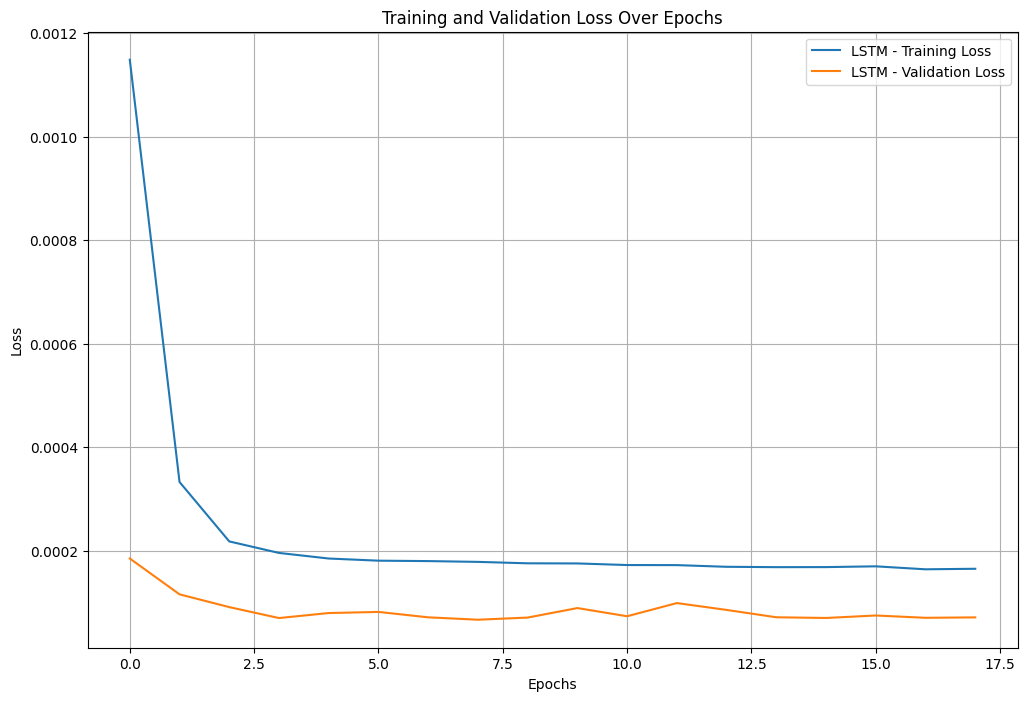

In [ ]:
plot_training_history(
    histories=[history_lstm],
    model_names=['LSTM']
)

# **TCN History**

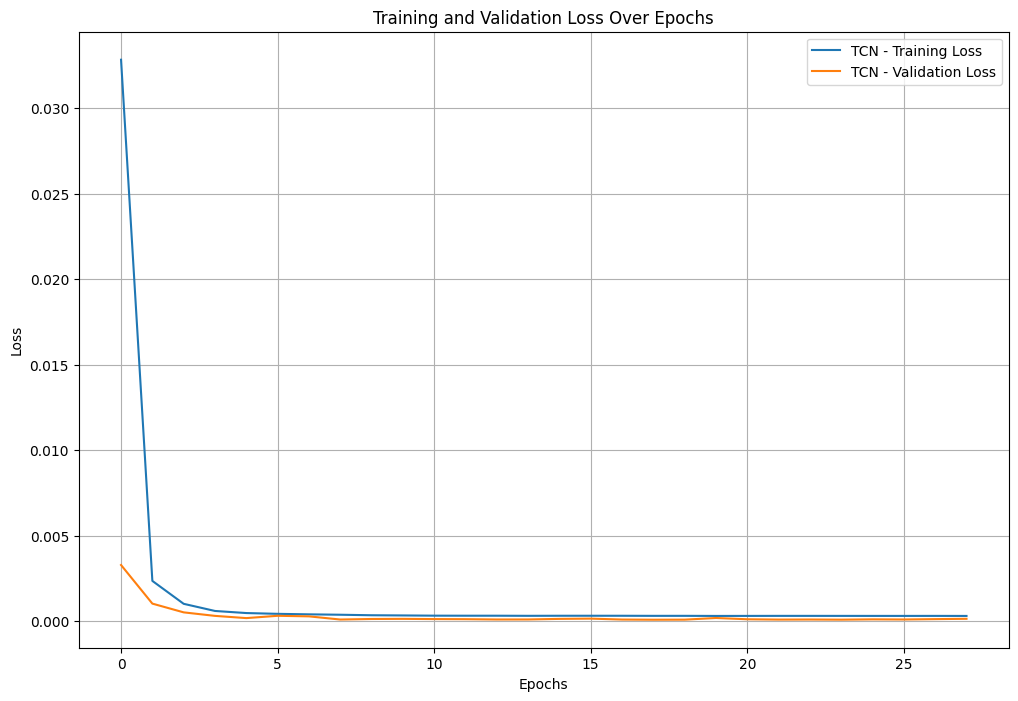

In [ ]:
plot_training_history(
    histories=[history_tcn],
    model_names=['TCN']
)

# **GRU History**

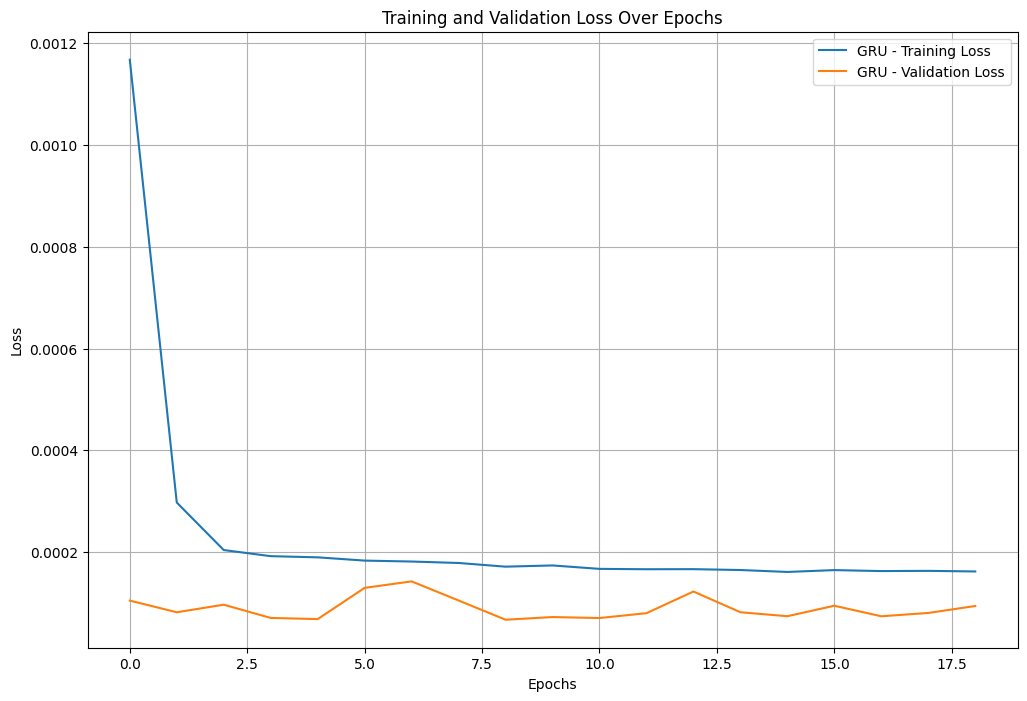

In [ ]:
plot_training_history(
    histories=[history_gru],
    model_names=['GRU']
)

In [ ]:
train_predict = model_GRU.predict(X_train)
test_predict = model_GRU.predict(X_test)

625/625 [==============================] - 2s 3ms/step


# **Plotting differnce between actual and predicted**

In [ ]:
def plot_result(y_train, y_test, train_predict, test_predict, sample_size):
    actual = np.append(y_train, y_test)
    predictions = np.append(train_predict, test_predict)

    # plotting sample not all data
    sample_actual = actual[:sample_size]
    sample_predictions = predictions[:sample_size]

    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(sample_size), sample_actual, color='orange', label='Normalized Temperature (Actual)')
    plt.plot(range(sample_size), sample_predictions, color='blue', label='Predictions')
    plt.axvline(x=len(y_train[:sample_size]), color='red', linestyle='--', label='Train/Test Split')
    plt.title('Sample of Normalized Temperature Over Time Predicted by GRU')
    plt.xlabel('Index')
    plt.ylabel('Normalized Temperature (0-1)')
    plt.legend()
    plt.show()

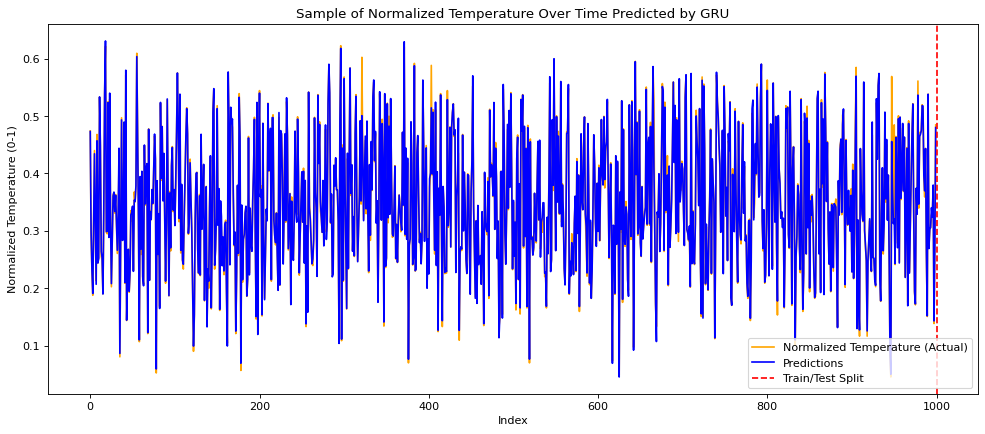

In [ ]:
plot_result(y_train, y_test, train_predict.flatten(), test_predict.flatten(), sample_size=1000)